In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

pip install dollarpy

In [3]:
import numpy as np
import dollarpy as dl

LIMIT = 10
class Dataset:
    def __init__(self, LIMIT=10, dir_path="drive/MyDrive/Datasets"):
        self.dataset = [[[] for _ in range(10)] for _ in range(10)]
        self.data = []
        self.labels = []
        limit_the_search = [j for i in range(10) for k in range(10) for j in range(i*100+(k*10)+1, i*100+(k*10)+LIMIT+1)]
        for i in limit_the_search:
          filepath = "{}/{}.txt".format(dir_path, i)
          try:
              lines = [line.strip() for line in open(filepath, "r")]
              class_id =  int(lines[1][len(lines[1]) - 1])
              user_id = int(lines[2][len(lines[2]) - 1])
              user_data = []
              for i, line in enumerate(lines[5:]):
                  if line:
                      user_data.append(list(map(float, line.split(',')))[0:3])
              self.dataset[user_id - 1][class_id - 1].append(user_data) 
              self.data.append(user_data)
              self.labels.append(class_id)
          except IOError as e:
              print("Unable to read dataset file {}!\n".format(filepath))

    def get_user(self, index):
        """Returns an array containing all the data saved for the user <<index>>"""
        return len(self.data[index])


In [4]:
data = Dataset()

# PART 1: K-Nearest Neighbors & DTW

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from joblib import Parallel, delayed
from numba import njit, prange
from numba.typed import List

@njit()
def distance(x, y):
  """
  This function computes the euclidean distance between two vectors
  """
  dist = 0.0
  for i in range(len(x)):
      diff = (x[i] - y[i])
      dist += diff * diff
  return dist

@njit(nogil=True)
def dtw_distance(time_serie1, time_serie2):
  """
  This function computes the DTW distance
  """
  l1, l2 = len(time_serie1), len(time_serie2)
  cost_matrix = np.full((l1 + 1, l2 + 1), np.inf)
  # Initialize the first cell
  cost_matrix[0, 0] = 0. 
  # populatte the cost matrix 
  for i in range(l1):
    for j in range(l2):
      cost_matrix[i+1, j+1] = distance(List(time_serie1[i]), List(time_serie2[j])) 
      cost_matrix[i+1, j+1] += min(cost_matrix[i, j +1], cost_matrix[i+1, j], cost_matrix[i, j])
  cost_matrix = np.sqrt(cost_matrix[1:, 1:]) # to get a matrix form
  return cost_matrix[-1, -1]/(l1+l2)

class KNN_DTW:
  """
  This class is a classifier using DTW as distance measure between pairs of time series data
  """
  def __init__(self, n_neighbors=1):
    self.n_neighbors = n_neighbors

  def fit(self, x, labels):
    """
    To fix the training set and the corresponding labels
    x: the training set containin list of the sequences
    labels: the labels corresponding to each sequences in x
    """
    self.x = np.array(x)
    self.labels = np.array(labels)
  

  def predict(self, x):
    """
    To predict the class of the test 
    """
    dist_matrix = np.zeros((x.shape[0], self.x.shape[0]))
    # compute the distance matrix between the training (self.x) and the test set(x)
    matrix = Parallel(n_jobs=-1, prefer="threads", verbose=0)(
            delayed(dtw_distance)(
                List(x[i]), List(self.x[j])
            )
            for i in range(len(x)) for j in range(len(self.x))
        )
    dist_matrix = np.array(matrix).reshape((len(x), -1))
    # the index of the k nearest neighbors
    indexes = dist_matrix.argsort()[:, :self.n_neighbors]
    # identifiers the labels of neighbors
    labels = self.labels[indexes]
    # get the majority votes between labels
    predictions = mode(labels, axis=1)[0]
    #print(predictions)
    return predictions

# Validation function
def test(user_id, dataset, labels, model, LIMIT=100):
  # split the dataset
  indexes = range(user_id*LIMIT, user_id*LIMIT+LIMIT)
  train_set = np.delete(dataset, indexes)
  train_labels = np.delete(labels, indexes)
  test_labels = labels[indexes]
  test_set = dataset[indexes]
  # Prediction
  model.fit(train_set, train_labels)
  predictions = model.predict(test_set)
  return accuracy_score(test_labels, predictions), predictions


def validation(dataset, labels, model, LIMIT=100):
  dataset = np.array(dataset)
  labels = np.array(labels)
  accuracies = []
  predictions = []
  for user_id in range(10):
    accuracy, prediction = test(user_id, dataset, labels, model, LIMIT)
    accuracies.append(accuracy)
    predictions.append(prediction)
    print("The user score {}: {}".format(user_id+1, accuracies[-1]))
  return accuracies, predictions


In [ ]:
# Test the 3-NN model
model = KNN_DTW(3)
accuracies, prediction = validation(np.array(data.data).T, data.labels, model, 100)
accuracies

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


The user score 1: 0.73


In [13]:
# plot the confusion metric
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_conf_mat(true_labels, pred_labels, LIMIT=100):
  for user_id in range(len(pred_labels)):
    print("The confusion matrix of user:", user_id+1)
    indexes = range(user_id*LIMIT, user_id*LIMIT+LIMIT)
    conf_mat = confusion_matrix(true_labels[indexes], pred_labels[user_id])
    df_cm = pd.DataFrame(conf_mat, range(10), range(10))
    sn.set(font_scale=1.4) # for label size
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True) # font size
    plt.show()


The confusion matrix of user: 1


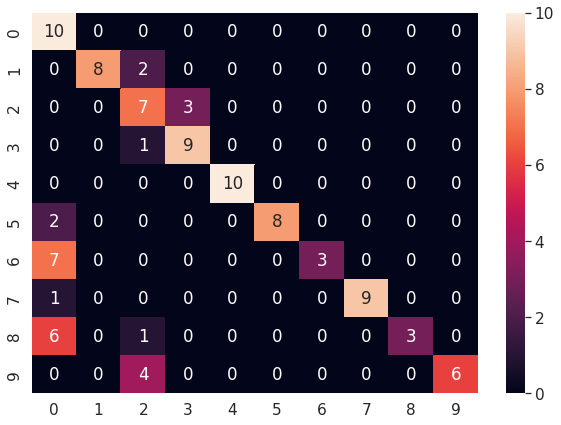

The confusion matrix of user: 2


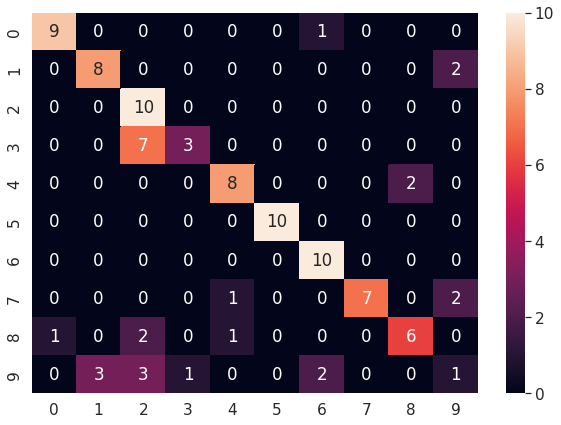

The confusion matrix of user: 3


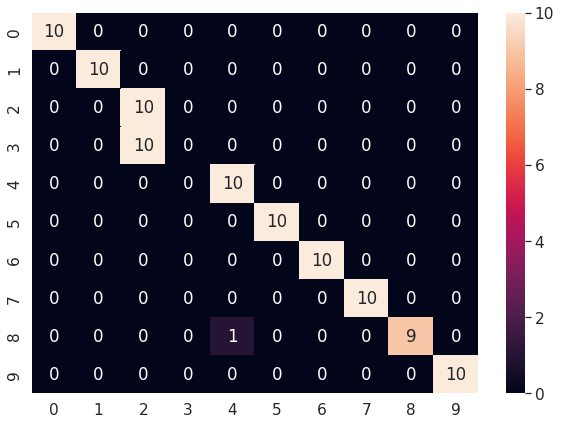

The confusion matrix of user: 4


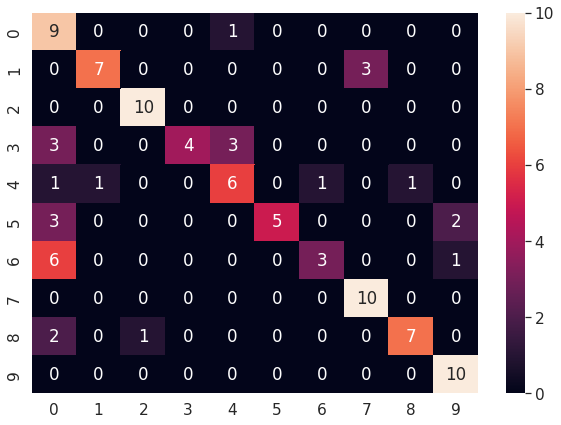

The confusion matrix of user: 5


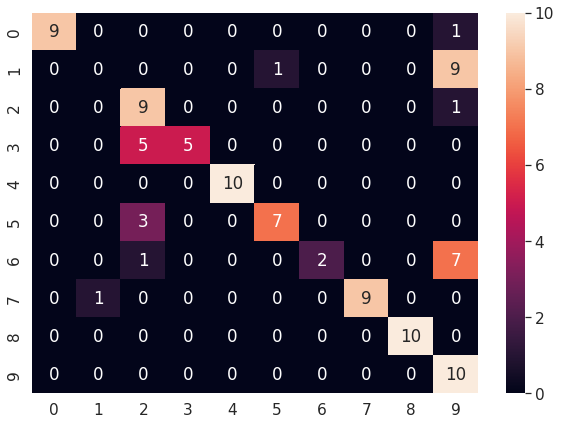

The confusion matrix of user: 6


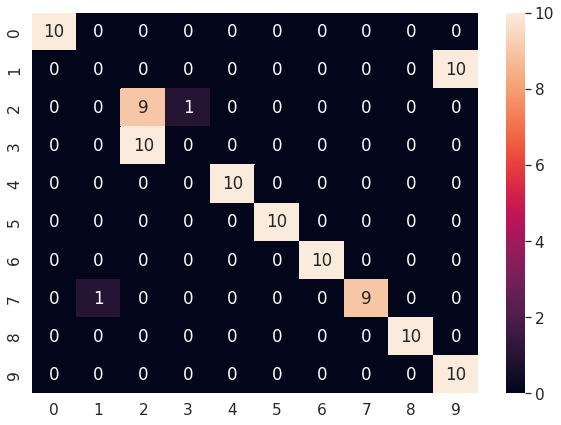

The confusion matrix of user: 7


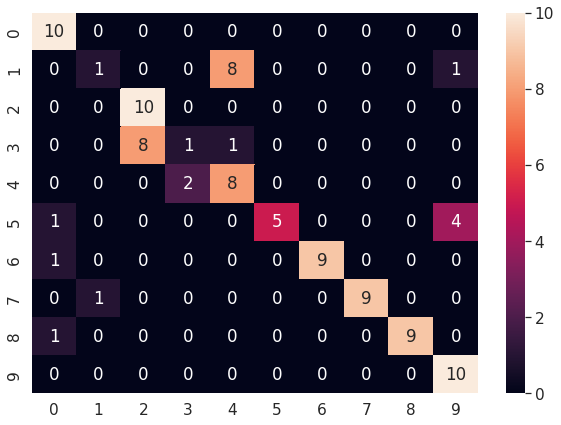

The confusion matrix of user: 8


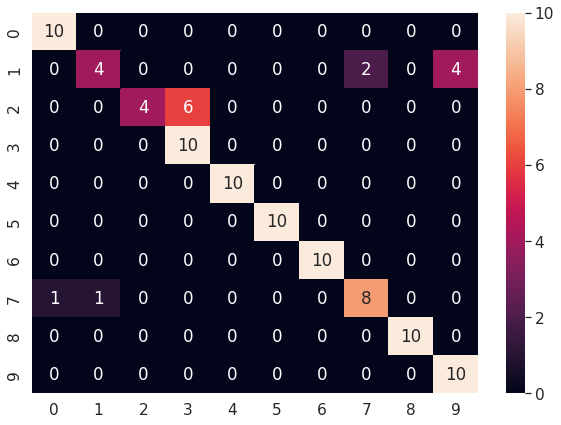

The confusion matrix of user: 9


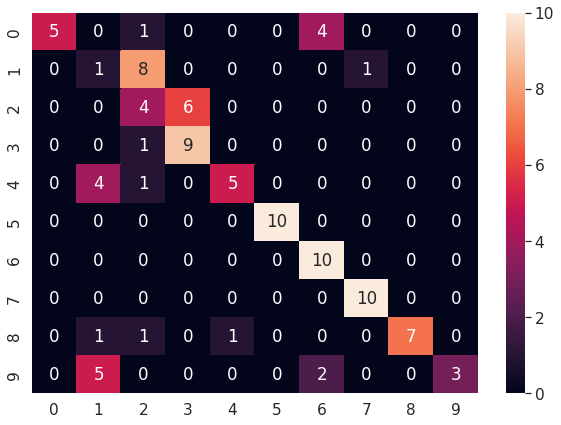

The confusion matrix of user: 10


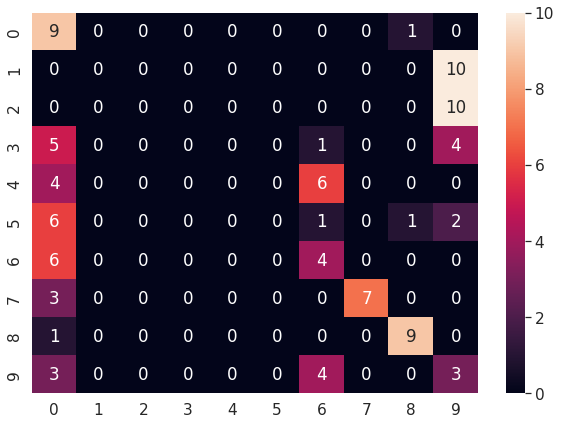

In [14]:
# plot the confusion matrix of the 3-NN model 
plot_conf_mat(np.array(data.labels), prediction, LIMIT=100)

# PART 2: Implementation of $P Recognizer

In [15]:
from sklearn.decomposition import PCA
from dollarpy import Recognizer, Template, Point
from sklearn.metrics import accuracy_score

pca_variances = []
final_dataset = []
for user_data in data.data:
  pca = PCA(n_components=2)
  new_data = pca.fit_transform(user_data)
  twod_data = [Point(*row) for row in new_data]
  final_dataset.append(twod_data)
  pca_variances.append(pca.explained_variance_ratio_)

print("The average explained variance ratio is over all the dataset: ", np.mean(pca_variances, axis=0))

The average explained variance ratio is over all the dataset:  [0.71587528 0.27444927]


In [16]:
def validation(dataset, labels, LIMIT=100):
  dataset = np.array(dataset)
  labels = np.array(labels)
  accuracies = []
  predictions_per_users = []
  for user_id in range(10):
    indexes = range(user_id*LIMIT, user_id*LIMIT+LIMIT)
    train_set = np.delete(dataset, indexes)
    train_labels = np.delete(labels, indexes)
    test_labels = labels[indexes]
    test_set = dataset[indexes]
    templates = []
    for i,d in enumerate(train_set):
      templates.append(Template(str(labels[i]), d))
    recognizer = Recognizer(templates)
    predictions=[]
    for t in test_set:
      result = recognizer.recognize(t)
      predictions.append(int(result[0]))
    acc = accuracy_score(test_labels, predictions)
    print("The user score {}: {}".format(user_id+1, acc))
    accuracies.append(acc)
    predictions_per_users.append(predictions)
  return accuracies, predictions_per_users

accuracies2, predictions = validation(final_dataset, data.labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


The user score 1: 0.89
The user score 2: 0.94
The user score 3: 0.91
The user score 4: 0.94
The user score 5: 0.98
The user score 6: 0.97
The user score 7: 0.91
The user score 8: 0.9
The user score 9: 0.9
The user score 10: 0.91


The confusion matrix of user: 1


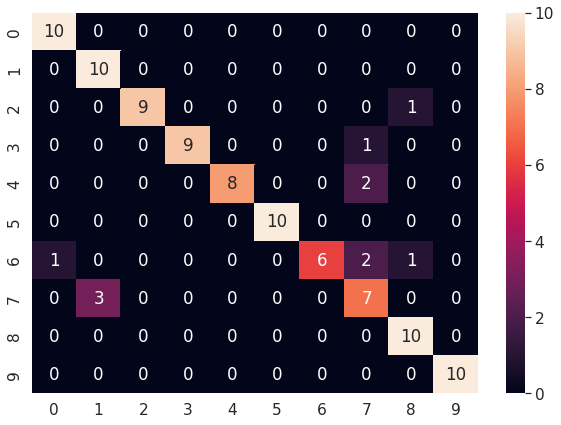

The confusion matrix of user: 2


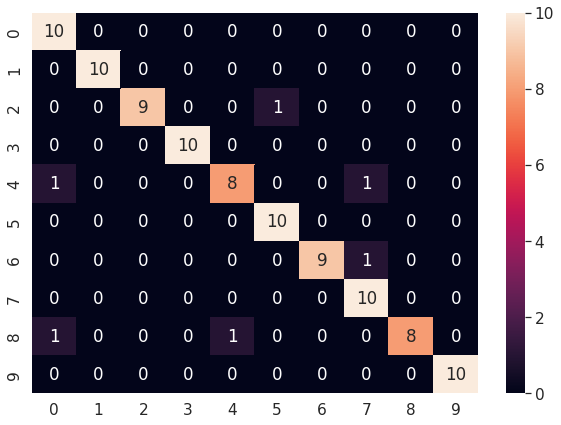

The confusion matrix of user: 3


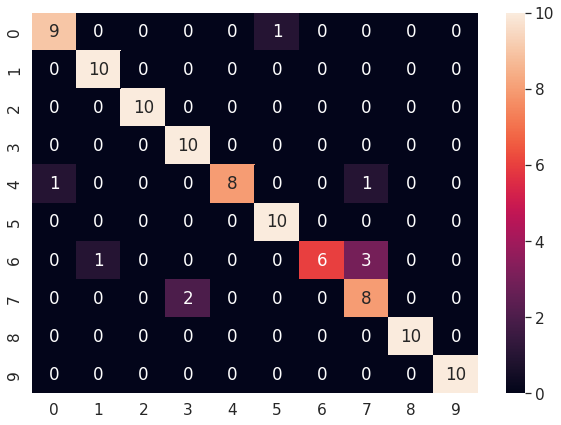

The confusion matrix of user: 4


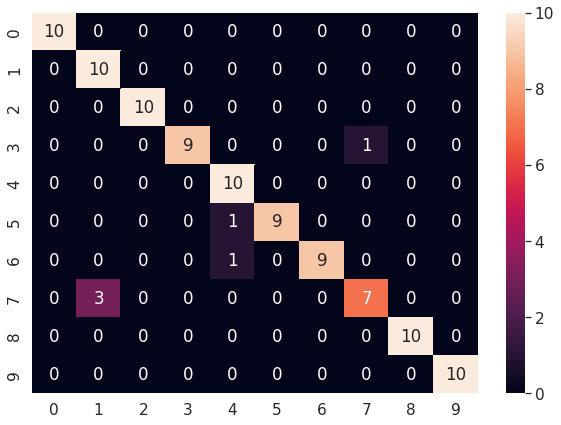

The confusion matrix of user: 5


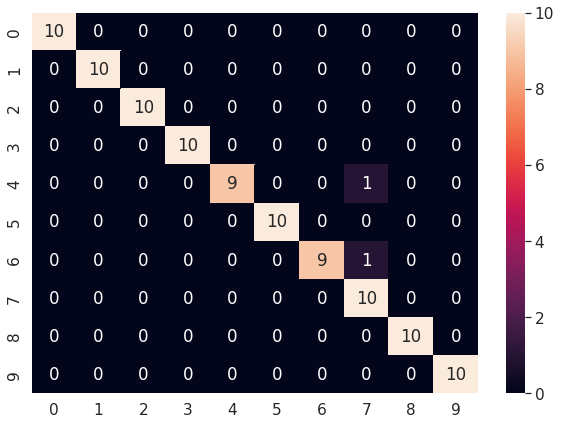

The confusion matrix of user: 6


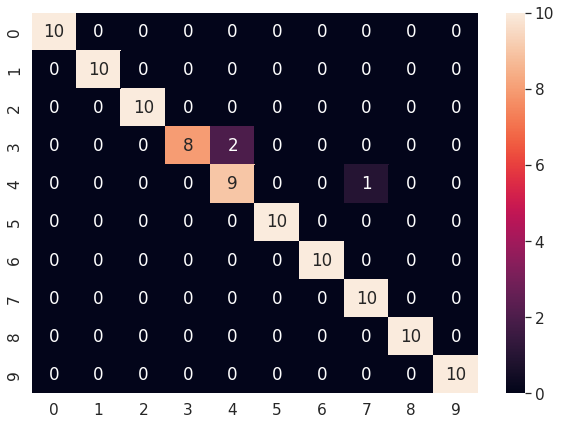

The confusion matrix of user: 7


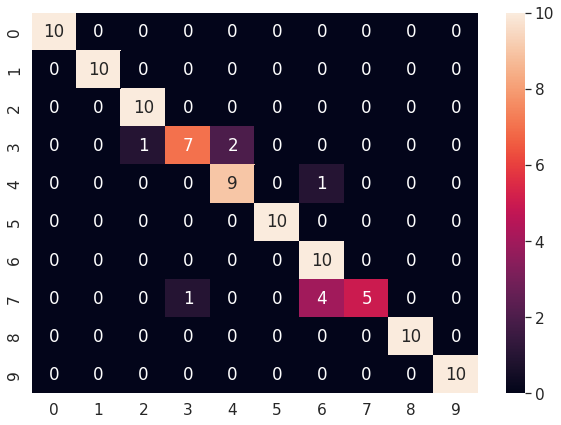

The confusion matrix of user: 8


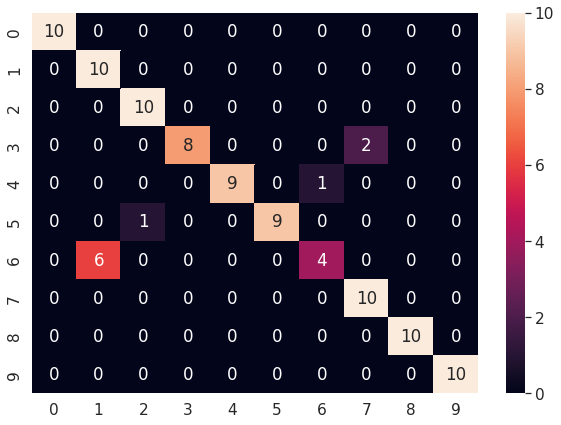

The confusion matrix of user: 9


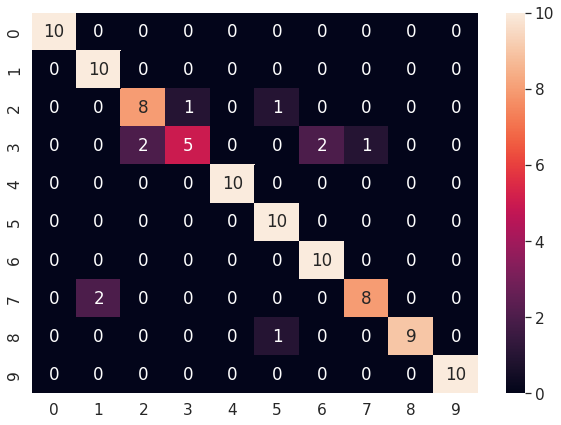

The confusion matrix of user: 10


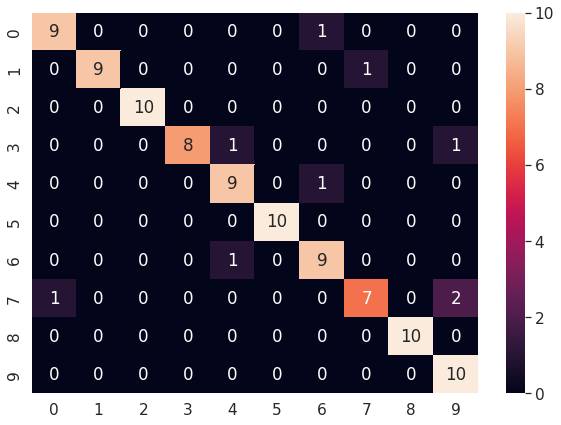

In [ ]:
plot_conf_mat(np.array(data.labels), predictions)

In [24]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print("Model $P dollar measure from the confusion matrixes")
true_labels = np.array(data.labels)
for user_id in range(len(predictions)):
    indexes = range(user_id*100, user_id*100+100)
    print("User ", user_id)
    print("The precision", precision_score(true_labels[indexes], predictions[user_id], average=None))
    print("The f1-score", f1_score(true_labels[indexes], predictions[user_id], average=None))
    print("The recall", recall_score(true_labels[indexes], predictions[user_id], average=None))
    print()

Model $P dollar
User  0
The precision [0.90909091 0.76923077 1.         1.         1.         1.
 1.         0.58333333 0.83333333 1.        ]
The f1-score [0.95238095 0.86956522 0.94736842 0.94736842 0.88888889 1.
 0.75       0.63636364 0.90909091 1.        ]
The recall [1.  1.  0.9 0.9 0.8 1.  0.6 0.7 1.  1. ]

User  1
The precision [0.83333333 1.         1.         1.         0.88888889 0.90909091
 1.         0.83333333 1.         1.        ]
The f1-score [0.90909091 1.         0.94736842 1.         0.84210526 0.95238095
 0.94736842 0.90909091 0.88888889 1.        ]
The recall [1.  1.  0.9 1.  0.8 1.  0.9 1.  0.8 1. ]

User  2
The precision [0.9        0.90909091 1.         0.83333333 1.         0.90909091
 1.         0.66666667 1.         1.        ]
The f1-score [0.9        0.95238095 1.         0.90909091 0.88888889 0.95238095
 0.75       0.72727273 1.         1.        ]
The recall [0.9 1.  1.  1.  0.8 1.  0.6 0.8 1.  1. ]

User  3
The precision [1.         0.76923077 1.        

In [21]:
len(true_labels)

1000